In [23]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import sys
import numpy as np
import scipy.cluster.hierarchy as sch
import pylab
import scipy
import matplotlib.pyplot as plt
import networkx as nx

sys.path.append('../src/')
import data_config  as dc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


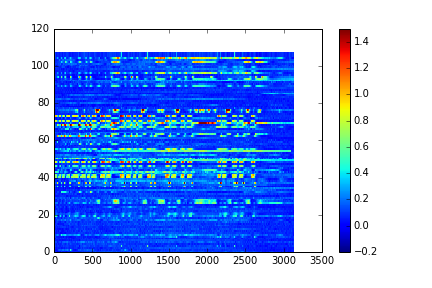

In [24]:
kato = dc.kato.data()
data = kato[0]["deltaFOverF_bc"].T

pc = plt.pcolormesh(data, vmin=-0.2, vmax=1.5)
plt.colorbar()

<IPython.core.display.Javascript object>


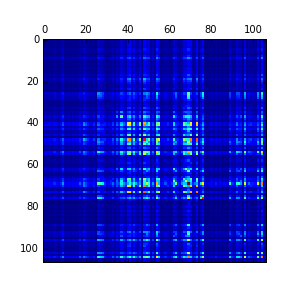

In [25]:
mean = np.mean(data, axis=1, keepdims=True)
standardized = (data-mean)
correlation = data.dot(data.T)
plt.matshow(correlation)

<IPython.core.display.Javascript object>


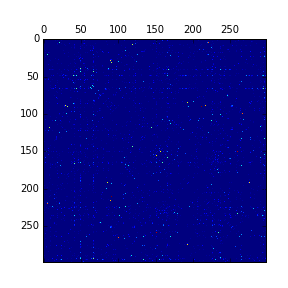

In [26]:
connectome = dc.connectome_networkx.data().to_directed()
adjacency = nx.to_numpy_matrix(connectome)
plt.matshow(adjacency)

In [27]:
print adjacency.shape
print correlation.shape

(299, 299)
(107, 107)


In [28]:
"""
By embedding a graph in 3+1 dimensions 
we can find a continuous surface on which the 
network lives 

This is enabled by a theorem in network science
that the probability of edge collisions
for a graph embedded in three dimensions is 
zero
"""
import numpy as np
import numpy.ma as ma
from scipy.integrate import odeint      

def spring_layout(y,t,w,k,n,d):              
    """
    y: an (n*2,d) dimensional matrix where y[:n]_i 
       is the position of the ith node in d dimensions
       and y[n:]_i is the velocity of the ith node
    w: (n,n) matrix of edge weights
    """
    y = np.copy(y.reshape((n*2,d)))    

    # rj across, ri down                               
    rs_from = np.tile(y[:n], (n,1,1))                  
    # ri across, rj down                               
    rs_to = np.transpose(rs_from, axes=(1,0,2))        
    # directional distance between each r_i and r_j    
    # dr_ij is the force from j onto i, i.e. r_i - r_j 
    dr = rs_to - rs_from                               
    # Used as a mask                                   
    nd_identity = np.eye(n).reshape((n,n,1))           
    # Physical distances between nodes                                 
    R = ma.array(                                  
          np.sqrt(np.sum(np.power(dr, 2.), axis=2, keepdims=True)),
          mask=nd_identity
        )      
    # Computing forces using the spring equation
    # this force equation is designed 
    # so that there is no potential
    # energy when R = w
    F = -k*(R-w)
    Fnet = np.sum(F, axis=1)
    a = Fnet #nodes have unit mass

    # Setting velocities                               
    y[:n] = np.copy(y[n:])                             
    # Entering the acceleration into the velocity slot 
    y[n:] = np.copy(a)                                 
    # Flattening it out for scipy.odeint to work       
    return np.array(y).reshape(n*2*d)   

def sim_particles(t, r, v, w, k=1.):             
                                                    
    d = r.shape[-1]                                 
    n = r.shape[0]                                  
    y0 = np.zeros((n*2,d))                          
    y0[:n] = r                                      
    y0[n:] = v                                      
    y0 = y0.reshape(n*2*d)  
    w = np.array([w]).reshape( (w.shape[0], w.shape[1], 1) ) 

    yf = odeint(                                    
        spring_layout,                            
        y0,                                         
        t,                                          
        args=(w,k,n,d)).reshape(t.shape[0],n*2,d) 
    return yf                                       



In [29]:
t = 10                         
t_f = t*10                     
t = np.linspace(0, t, num=t_f) 
N = adjacency.shape[0]
w = adjacency
  
r0 = np.random.rand(N,3)
d = r0.shape[-1]                                 
n = r0.shape[0] 
v0 = r0*0.
k=1.

y0 = np.zeros((n*2,d))                          
y0[:n] = r0                                      
y0[n:] = v0 

In [30]:
y = np.copy(y0.reshape(n*2*d).reshape((n*2,d)))    

# rj across, ri down                               
rs_from = np.tile(y[:n], (n,1,1))                  
# ri across, rj down                               
rs_to = np.transpose(rs_from, axes=(1,0,2))        
# directional distance between each r_i and r_j    
# dr_ij is the force from j onto i, i.e. r_i - r_j 
dr = rs_to - rs_from                               
# Used as a mask                                   
nd_identity = np.eye(n).reshape((n,n,1))           
# Physical distances between nodes                                 
R = ma.array(                                  
      np.sqrt(np.sum(np.power(dr, 2.), axis=2, keepdims=True)),
      mask=nd_identity
    )      
print R.shape
print w.shape
wn = np.array([w]).reshape( (w.shape[0], w.shape[1], 1) ) 
wn.shape

# Computing forces using the spring equation
# this force equation is designed 
# so that there is no potential
# energy when R = w
F = -k*(R-wn)
Fnet = np.sum(F, axis=1)
a = Fnet #nodes have unit mass

# Setting velocities                               
y[:n] = np.copy(y[n:])                             
# Entering the acceleration into the velocity slot 
y[n:] = np.copy(a)                                 
# Flattening it out for scipy.odeint to work       
np.array(y).reshape(n*2*d)   

(299, 299, 1)
(299, 299)


array([   0.        ,    0.        ,    0.        , ..., -177.13270995,
       -177.13270995, -177.13270995])

In [11]:
rf = sim_particles(t,r0,v0,w)


In [12]:
np.save("../data/spaceembedding1.npy", rf)

In [14]:
rf.shape

(100, 598, 3)

<IPython.core.display.Javascript object>


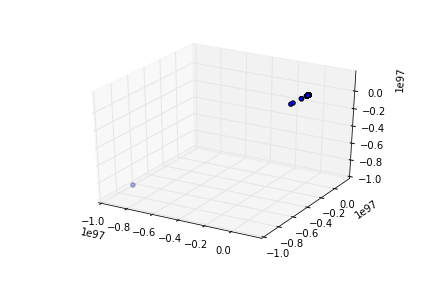

In [32]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = rf[:,:n,:]
y = rf[:,:n,1]
z = rf[:,:n,2]
ax.scatter(x,y,z)



In [39]:
rf[-1,:n,:].shape
rf.reshape((100*299,3))

(100, 299, 3)

In [41]:
import numpy as np


import os                                     
import sys                                    
import numpy as np                            
import scipy.stats                            
                                              
sys.path.append("../src/")                                      
import matplotlib.cm as cm

# colors = cm.viridis(t) 


from vispy import app, visuals, scene

# build your visuals                                                
Scatter3D = scene.visuals.create_visual_node(visuals.MarkersVisual) 
                                                                    
# The real-things : plot using scene                                
# build canvas                                                      
canvas = scene.SceneCanvas(keys='interactive', show=True)           
                                                                    
# Add a ViewBox to let the user zoom/rotate                         
view = canvas.central_widget.add_view()                             
view.camera = 'turntable'                                           
view.camera.fov = 45                                                
view.camera.distance = 10


# plot
p1 = Scatter3D(parent=view.scene)
p1.set_gl_state('translucent', blend=False, depth_test=True)
p1.set_data(rf[-1,:n,:])#, face_color=colors)
p1.symbol = visuals.marker_types[10]

# run
app.run()


/Library/Python/2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
